# Bike sharing demand forecast

This notebook along with the repository contains a simple code to create a `LGBMRegressor` which could be used to predict bike sharing demand.

Dataset was downloaded from Kaggle: https://www.kaggle.com/datasets/imakash3011/rental-bike-sharing


In [1]:
# Dependencies

import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GridSearchCV
)

import sys

from src.features.build_features import trig_transformer, spline_transformer, get_lag_features
from src.visualization import pacf_plot, residual_plot
from src.model.predict_model import make_prediction, evaluate_model

In [2]:
data_path = "/Users/damir_bogdan/Projects/bike-sharing-time-series/data/raw/hour.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


The following cell contains some feature engineering inspired by: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [5]:
# Make sine/cosine and spline features

df = trig_transformer(df, 'hr', 24)
df = trig_transformer(df, 'mnth', 12)
df = trig_transformer(df, 'weekday', 7)

df = spline_transformer(df, 'hr', 24)
df = spline_transformer(df, 'mnth', 12)
df = spline_transformer(df, 'weekday', 7)

In [6]:
# Ispect columns
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'mnth_spline_0', 'mnth_spline_1',
       'mnth_spline_2', 'mnth_spline_3', 'mnth_spline_4', 'mnth_spline_5',
       'mnth_spline_6', 'mnth_spline_7', 'mnth_spline_8', 'mnth_spline_9',
       'mnth_spline_10', 'mnth_spline_11', 'weekday_spline_0',
       'weekday_spline_1', 'weekday_spline_2', 'weekday_spline_3',
       'weekday_spline_4', 'weekday_spline_5', 'weekday_spline_6',
       'weekday_spline_7', 'weekday_spline_8', 'weekday_spline_9',
       'weekday_spline_10', 'weekday_spline_11'],
      dtype='object')

Pacf plot is plotted to determine if there would be any useful lag features for the prediction.

<Figure size 1200x600 with 0 Axes>

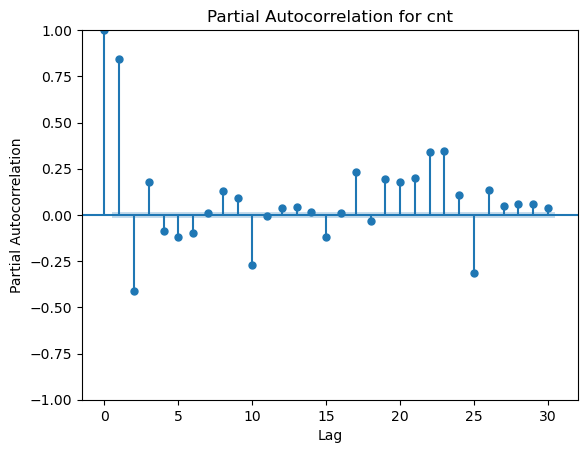

In [7]:
pacf_plot(df['cnt'], lags=30)

30 days of lag were feature engineered for the model to work with.

In [8]:
df = get_lag_features(df, 'cnt', 30)

In [9]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'mnth_spline_0', 'mnth_spline_1',
       'mnth_spline_2', 'mnth_spline_3', 'mnth_spline_4', 'mnth_spline_5',
       'mnth_spline_6', 'mnth_spline_7', 'mnth_spline_8', 'mnth_spline_9',
       'mnth_spline_10', 'mnth_spline_11', 'weekday_spline_0',
       'weekday_spline_1', 'weekday_spline_2', 'weekday_spline_3',
       'weekday_spline_4', 'weekday_spline_5', 'weekday_spline_6',
       'weekday_spline_7', 'weekday_spline_8', 'weekday_spline_9',
       'weekday_spline_10', 'weekday_spline_11', 'cnt_lag_1', 'cnt_lag_2',
   

In [10]:
X = df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
        'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'mnth_spline_0', 'mnth_spline_1',
       'mnth_spline_2', 'mnth_spline_3', 'mnth_spline_4', 'mnth_spline_5',
       'mnth_spline_6', 'mnth_spline_7', 'mnth_spline_8', 'mnth_spline_9',
       'mnth_spline_10', 'mnth_spline_11', 'weekday_spline_0',
       'weekday_spline_1', 'weekday_spline_2', 'weekday_spline_3',
       'weekday_spline_4', 'weekday_spline_5', 'weekday_spline_6',
       'weekday_spline_7', 'weekday_spline_8', 'weekday_spline_9',
       'weekday_spline_10', 'weekday_spline_11', 'cnt_lag_1', 'cnt_lag_2',
       'cnt_lag_3', 'cnt_lag_4', 'cnt_lag_5', 'cnt_lag_6', 'cnt_lag_7',
       'cnt_lag_8', 'cnt_lag_9', 'cnt_lag_10', 'cnt_lag_11', 'cnt_lag_12',
       'cnt_lag_13', 'cnt_lag_14', 'cnt_lag_15', 'cnt_lag_16', 'cnt_lag_17',
       'cnt_lag_18', 'cnt_lag_19', 'cnt_lag_20', 'cnt_lag_21', 'cnt_lag_22',
       'cnt_lag_23', 'cnt_lag_24', 'cnt_lag_25', 'cnt_lag_26', 'cnt_lag_27',
       'cnt_lag_28', 'cnt_lag_29', 'cnt_lag_30']]

X_nonengineered = df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',]]
y = df['cnt']


In [11]:
X_train_ne, X_test_ne, y_train_ne, y_test_ne = train_test_split(X_nonengineered, y, random_state=42, test_size=24*31, shuffle=False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=24*31, shuffle=False)

In [13]:
# Baseline model - lgbm with default values and no engineered features added

lgb = LGBMRegressor(verbose=-1)


lgb.fit(X_train_ne, y_train_ne)
print(lgb.get_params())


y_train_baseline = make_prediction(lgb,X_train_ne)
y_test_baseline = make_prediction(lgb,X_test_ne)


# Evaluate baseline
print("Train set evaluation", evaluate_model(y_train_baseline, y_train_ne))
print("Test set evaluation", evaluate_model(y_test_baseline, y_test_ne))


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}
Train set evaluation {'mean_absolute_error': 23.47351968740607, 'root_mean_squared_error': 36.5821415564155, 'r2_score': 0.9596099054799261}
Test set evaluation {'mean_absolute_error': 42.064516129032256, 'root_mean_squared_error': 64.7202416359778, 'r2_score': 0.8456526313868982}


In [14]:
# Adding engineered features 

lgb = LGBMRegressor(verbose=-1)


lgb.fit(X_train, y_train)
print(lgb.get_params())


y_train_baseline = make_prediction(lgb,X_train)
y_test_baseline = make_prediction(lgb,X_test)


# Evaluate baseline
print("Train set evaluation", evaluate_model(y_train_baseline, y_train))
print("Test set evaluation", evaluate_model(y_test_baseline, y_test))


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}
Train set evaluation {'mean_absolute_error': 22.59224526600541, 'root_mean_squared_error': 33.23161335595754, 'r2_score': 0.9666696810048166}
Test set evaluation {'mean_absolute_error': 31.844086021505376, 'root_mean_squared_error': 45.91269766035985, 'r2_score': 0.9223244044389486}


Adding engineered features significantly improved the prediction on the test set.
Next step will be to optimize using grid search cross validation.
Main metric to be optimized for will be `neg_mean_absolute_error` - MAE which does not penalize for having some outlier prediction which are too far of from the original demand.

In [15]:
# Grid search to optimize parameters
lgb = LGBMRegressor(verbose=-1, random_state=42)

param_grid = {
    'max_depth':[-1, 5, 6, 7],
    'n_estimators': [50, 100, 150],    
    'num_leaves': [31, 63, 70, 90],     
}

tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)
gscv = GridSearchCV(estimator=lgb,
                    param_grid=param_grid,
                    cv=tss,
                    scoring='neg_mean_absolute_error', verbose=10)

gscv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 1/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-44.010 total time=   0.2s
[CV 2/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 2/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-38.509 total time=   0.3s
[CV 3/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 3/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-46.078 total time=   0.2s
[CV 4/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 4/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-46.505 total time=   0.2s
[CV 5/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 5/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-41.598 total time=   0.2s
[CV 1/5; 2/48] START max_depth=-1, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=720),
             estimator=LGBMRegressor(random_state=42, verbose=-1),
             param_grid={'max_depth': [-1, 5, 6, 7],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [31, 63, 70, 90]},
             scoring='neg_mean_absolute_error', verbose=10)

In [16]:
print("\n The best estimator across all searched params:\n", gscv.best_estimator_)


 The best estimator across all searched params:
 LGBMRegressor(max_depth=7, n_estimators=150, num_leaves=90, random_state=42,
              verbose=-1)


In [17]:
# Reatraining with new parameters

lgmb_best = gscv.best_estimator_

# Now you have the parameters with which you can initialize a new model
params = lgmb_best.get_params()

# Create a new model with best parameters
lgb = LGBMRegressor(**params)

lgb.fit(X_train, y_train)

LGBMRegressor(max_depth=7, n_estimators=150, num_leaves=90, random_state=42,
              verbose=-1)

In [18]:
y_pred = lgb.predict(X_test)

In [19]:
evaluate_model(y_test, y_pred)

{'mean_absolute_error': 29.440751876386642,
 'root_mean_squared_error': 43.09244903607934,
 'r2_score': 0.9229765477329008}

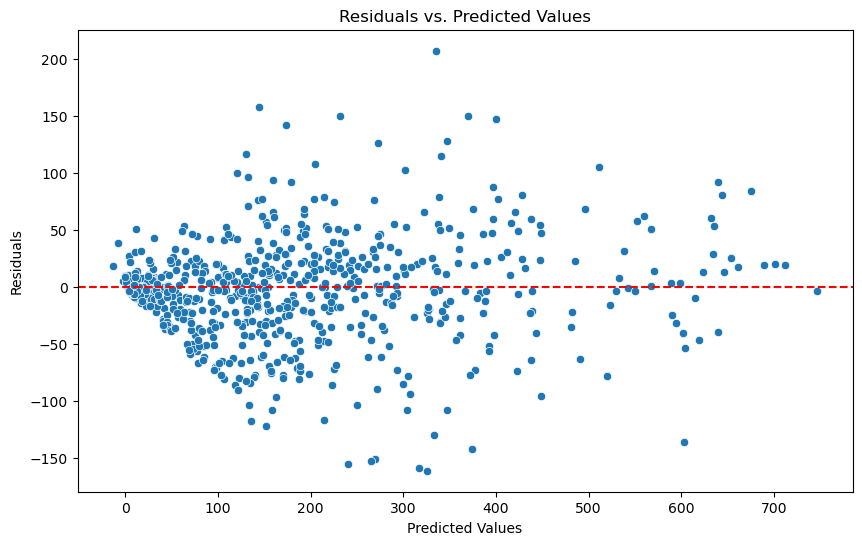

In [20]:
residual_plot(y_test, y_pred)

We can see that there is still quite some room for improvement, using different optimization technique (even expandinx the hyperparameter values in the gridsearch) or feature engineering different features could help improve this model.